In [1]:
import dask_ml.joblib
from dask.distributed import Client
from sklearn.externals import joblib
from sklearn.datasets import fetch_mldata
from sklearn.linear_model import SGDClassifier
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


(-0.5, 27.5, 27.5, -0.5)

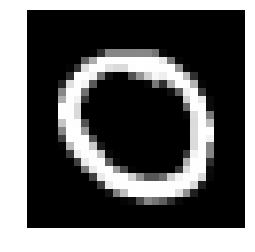

In [4]:
some_digit = X[3000]
some_digit_img = some_digit.reshape(28,28)
plt.imshow(some_digit_img, cmap="gray")
plt.axis("off")

In [5]:
# split our data into train & validation sets like good data scientists
TEST_SET_SIZE = 60_000
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = X[:TEST_SET_SIZE], X[TEST_SET_SIZE:], y[:TEST_SET_SIZE], y[TEST_SET_SIZE:]

shuffle_index = np.random.RandomState().permutation(60_000)

X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [6]:
# let's play with Dask
if "client" in locals():
    client.close()
    
client = Client(diagnostics_port=8786)
client

/home/david/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Client Scheduler: tcp://127.0.0.1:37695 Dashboard: http://127.0.0.1:8786/status,Cluster Workers: 4 Cores: 4 Memory: 33.70 GB


In [7]:
%%time
# Binary classifer: Is it a 5?

# create labels just for 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=RANDOM_STATE, max_iter=50)

with joblib.parallel_backend("dask",
                      scatter=[X_train, y_train_5]):
    sgd_clf.fit(X_train, y_train_5)
sgd_clf

CPU times: user 3.52 s, sys: 119 ms, total: 3.64 s
Wall time: 3.59 s


array([ True])

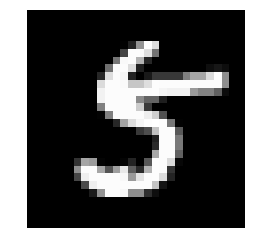

In [16]:
five_idx = np.where(y_train_5 == True)[0][0]
five_digit = X_train[five_idx]
five_digit_img = five_digit.reshape(28,28)
plt.imshow(five_digit_img, cmap="gray")
plt.axis("off")
sgd_clf.predict([five_digit])

In [17]:
# Performance Measures

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,random_state=RANDOM_STATE)

# "manually" doing cross-validation with stratified kfolds
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96645
0.96955
0.96605


In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(
    sgd_clf,
    X_train,
    y_train_5,
    cv=3,
    scoring="accuracy",
)

333,328,333,350,000
